In [ ]:
# import packages 
import scanpy.external as sce
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from seaborn import despine
from seaborn import axes_style
from matplotlib.pyplot import suptitle
import matplotlib.colors

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

# load results 
subset_results_file = './write/kras_organoids_subset.h5ad' 
adata_subset = sc.read(subset_results_file)

### Human KRAS patient Stage IA data signature
- Collaborators at UCLA performed differential expression analysis using Epcam+ cells from human patient (n=2) Kras mutant Stage IA patients compared to surrounnding normal tissues.
- Differential expression data was filtered for genes with positive log fold changes and FDR less than 0.05. The list was then used to determine if a human GGO score correlated with a KY mouse organoid cluster 

In [76]:
# Calculate GGO signature

GGO_human = pd.read_excel('/n/data2/bch/hemonc/ckim/AARON/20190114_KRASYFP_7weeks/scanpy_analysis/KRAS_GGO_EPCAM_edgeR_012420.xlsx', sheet_name='Sheet1', header=0)
GGO = GGO_human[GGO_human['genes'].apply(lambda x: isinstance(x, str))] # remove non-strings
GGO = GGO.loc[(GGO['logFC'] > 0) & (GGO['FDR'] < 0.05)] 
GGO_list = GGO['genes'].tolist() 
GGO_list = [x.lower() for x in GGO_list] 
GGO_list = [x.capitalize() for x in GGO_list] 
GGO_list_final = [x for x in GGO_list if x in adata_subset.var_names] 

# Calculate

# Barcode ids already defined in adata_subset.obs

# create the marker dict 
marker_genes = dict()
marker_genes['GGO_sig_human'] = GGO_list_final

# Calculate score
def evaluate_partition(anndata, marker_dict, gene_symbol_key=None, partition_key=None):
    # Inputs:
    #    anndata         - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or 
    #                      an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker 
    #                      genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                      'louvain_r1' 

    #Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise
        

    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names
        
    
    # I created a column based on index. This allows z-score calculation on single cells rather than clusters
    clusters = np.unique(anndata.obs[partition_key])
    n_clust = len(clusters)
    n_groups = len(marker_dict)
    
    marker_res = np.zeros((n_groups, n_clust))
    z_scores = sc.pp.scale(anndata, copy=True) # remove scaling if data is already scaled

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        j = 0
        for clust in clusters:
            cluster_cells = np.in1d(z_scores.obs[partition_key], clust)
            marker_genes = np.in1d(gene_ids, marker_dict[group])
            marker_res[i,j] = z_scores.X[np.ix_(cluster_cells,marker_genes)].mean()
            j += 1
        i+=1

    variances = np.nanvar(marker_res, axis=0)
    if np.all(np.isnan(variances)):
        print("No variances could be computed, check if your cell markers are in the data set.")
        print("Maybe the cell marker IDs do not correspond to your gene_symbol_key input or the var_names")
        raise

    marker_res_df = pd.DataFrame(marker_res, columns=clusters, index=marker_dict.keys())
    
    return marker_res_df

# Calculate the z-score
df = evaluate_partition(adata_subset, marker_genes, gene_symbol_key=None, partition_key = 'index1')

# Transpose the dataframe
df_transposed = df.transpose()

# save signatures
adata_subset.obs['GGO_sig_human'] = df_transposed['GGO_sig_human']

# save the newly added columns
adata_subset.write(subset_results_file)

#### HALLMARK Wnt beta cat signauture: MSigDB (Broad)
#### LUAD Progression associated genes are from KrasG12D;cMyc GEMM: Murphy 2019 Cancer

In [43]:
HALLMARK_WNT = pd.read_csv('hallmark_WNT_BCAT.csv', header=0)
Murphy_LUAD_progression = pd.read_csv('Murphy_EarlyLUAD.csv', header=0)

# Hallmark Wnt signature - MSigDB (Broad)
HALLMARK_WNT_list = HALLMARK_WNT['Gene_symbol'].tolist()
HALLMARK_WNT_list = [x.lower() for x in HALLMARK_WNT_list]
HALLMARK_WNT_list = [x.capitalize() for x in HALLMARK_WNT_list] 
HALLMARK_WNT_list_final = [x for x in HALLMARK_WNT_list if x in adata_subset.var_names] 

# LUAD progression signature from Murphy 2019 Cancers
Murphy_LUAD_progression = pd.read_csv('Murphy_EarlyLUAD.csv', header=0)
Murphy_LUAD_progression_list = Murphy_LUAD_progression['Gene_symbol'].tolist()
Murphy_LUAD_progression_list_final = [x for x in Murphy_LUAD_progression_list if x in adata_subset.var_names] 

# create the marker dict 
marker_genes = dict()
marker_genes['HALLMARK_WNT'] = HALLMARK_WNT_list
marker_genes['LUAD progression'] = Murphy_LUAD_progression_list_final

# Calculate score
def evaluate_partition(anndata, marker_dict, gene_symbol_key=None, partition_key=None):
    # Inputs:
    #    anndata         - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or 
    #                      an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker 
    #                      genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                      'louvain_r1' 

    #Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise
        

    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names
        
    
    # I created a column based on index. This allows z-score calculation on single cells rather than clusters
    clusters = np.unique(anndata.obs[partition_key])
    n_clust = len(clusters)
    n_groups = len(marker_dict)
    
    marker_res = np.zeros((n_groups, n_clust))
    z_scores = sc.pp.scale(anndata, copy=True) # remove scaling if data is already scaled

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        j = 0
        for clust in clusters:
            cluster_cells = np.in1d(z_scores.obs[partition_key], clust)
            marker_genes = np.in1d(gene_ids, marker_dict[group])
            marker_res[i,j] = z_scores.X[np.ix_(cluster_cells,marker_genes)].mean()
            j += 1
        i+=1

    variances = np.nanvar(marker_res, axis=0)
    if np.all(np.isnan(variances)):
        print("No variances could be computed, check if your cell markers are in the data set.")
        print("Maybe the cell marker IDs do not correspond to your gene_symbol_key input or the var_names")
        raise

    marker_res_df = pd.DataFrame(marker_res, columns=clusters, index=marker_dict.keys())
    
    return marker_res_df

# Calculate the z-score
df = evaluate_partition(adata_subset, marker_genes, gene_symbol_key=None, partition_key = 'index1')

# Transpose the dataframe
df_transposed = df.transpose()

# save signatures
adata_subset.obs['HALLMARK_WNT'] = df_transposed['HALLMARK_WNT']
adata_subset.obs['LUAD progression'] = df_transposed['LUAD progression']

# save the newly added columns
adata_subset.write(subset_results_file)


#### Human KRAS<sup>G12D</sup> iPSC signature
- Differentially expressed genes in the +dox positive vs -dox samples were used as input. Refer to figure 5

In [ ]:
# GENERATE LIST OF GENES
ipsc_initial = pd.read_excel('/n/data2/bch/hemonc/ckim/AARON/KY_organoid_analysis/ipsc_DE_genes.xlsx', sheet_name='Sheet 1', header=0)
ipsc = ipsc_initial.loc[(ipsc_initial['avg_logFC'] > 0) & (ipsc_initial['p_val_adj'] < 0.05)] # select positive log values
ipsc_list = ipsc['row.names'].tolist() # Make list of gene names
ipsc_list = [x.lower() for x in ipsc_list] # lower names
ipsc_list = [x.capitalize() for x in ipsc_list] # capitalize names
ipsc_list_final = [x for x in ipsc_list if x in adata_subset.var_names] # remove genes not in adata.var


# create the marker dict 
marker_genes = dict()
marker_genes['iPSC_KRAS_HUMAN'] = ipsc_list_final

# Calculate score
def evaluate_partition(anndata, marker_dict, gene_symbol_key=None, partition_key=None):
    # Inputs:
    #    anndata         - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or 
    #                      an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker 
    #                      genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                      'louvain_r1' 

    #Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise       

    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names
           
    clusters = np.unique(anndata.obs[partition_key])
    n_clust = len(clusters)
    n_groups = len(marker_dict)
    
    marker_res = np.zeros((n_groups, n_clust))
    z_scores = sc.pp.scale(anndata, copy=True) # remove scaling if data is already scaled

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        j = 0
        for clust in clusters:
            cluster_cells = np.in1d(z_scores.obs[partition_key], clust)
            marker_genes = np.in1d(gene_ids, marker_dict[group])
            marker_res[i,j] = z_scores.X[np.ix_(cluster_cells,marker_genes)].mean()
            j += 1
        i+=1

    variances = np.nanvar(marker_res, axis=0)
    if np.all(np.isnan(variances)):
        print("No variances could be computed, check if your cell markers are in the data set.")
        print("Maybe the cell marker IDs do not correspond to your gene_symbol_key input or the var_names")
        raise

    marker_res_df = pd.DataFrame(marker_res, columns=clusters, index=marker_dict.keys())
    
    return marker_res_df

# Calculate the z-score
df = evaluate_partition(adata_subset, marker_genes, gene_symbol_key=None, partition_key = 'index1')

# Transpose the dataframe
df_transposed = df.transpose()

# save signatures
adata_subset.obs['iPSC_KRAS_HUMAN'] = df_transposed['iPSC_KRAS_HUMAN']

# save the newly added columns
adata_subset.write(subset_results_file)

#### Calculate 7 weeks Kras GEMM signature score

Trying to set attribute `.uns` of view, copying.


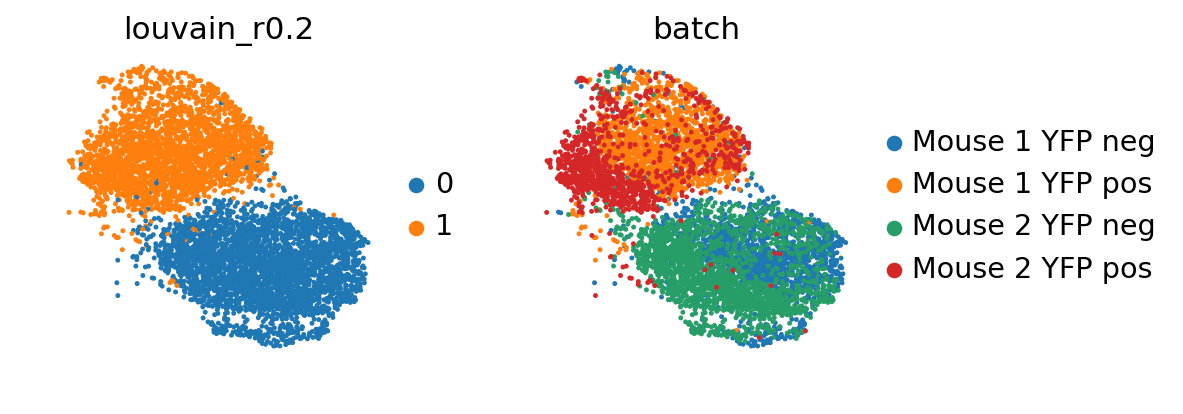

In [24]:
GEMM_data = '/n/data2/bch/hemonc/ckim/AARON/KY_epithelial_analysis/write/invivo_epithelial_subset.h5ad'
adata_GEMM = sc.read(GEMM_data)

# SUBSET AT2 CLUSTERS FROM 7 WEEK KRAS-G12D GEMM DATASET
adata_at2 = adata_GEMM[adata_GEMM.obs['louvain_r0.2'].isin(['0','1'])]

rcParams['figure.figsize']=2.5,2.5
sc.pl.umap(adata_at2, color=['louvain_r0.2','batch'], frameon=False, ncols=2)

Create signatures using DE analysis from 7 week KrasG12D GEMM data

In [32]:
GEMM_DE = pd.read_excel('/n/data2/bch/hemonc/ckim/AARON/KY_epithelial_analysis/at2_only_DE_top1000.xlsx', header=0)

# AT2 YFP NEGATIVE
C0_DE = GEMM_DE.loc[(GEMM_DE['0_p'] < 0.05)] # significant genes
C0_DE_list = C0_DE['0_n'].tolist() 
C0_DE_list_final = [x for x in C0_DE_list if x in adata_subset.var_names] 

# AT2 YFP POSITIVE
C1_DE = GEMM_DE.loc[(GEMM_DE['1_p'] < 0.05)] # significant genes
C1_DE_list = C1_DE['1_n'].tolist() 
C1_DE_list_final = [x for x in C1_DE_list if x in adata_subset.var_names] 

print('Length GEMM AT2 YFP- DE list:',len(C0_DE_list_final))
print('Length GEMM AT2 YFP+ DE list:',len(C1_DE_list_final))

# GENE LIST DICT 
marker_genes = dict()
marker_genes['GEMM_AT2_YFPneg'] = C0_DE_list_final
marker_genes['GEMM_AT2_YFPpos'] = C1_DE_list_final

# Calculate score
def evaluate_partition(anndata, marker_dict, gene_symbol_key=None, partition_key=None):
    # Inputs:
    #    anndata         - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or 
    #                      an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker 
    #                      genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                      'louvain_r1' 

    #Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise
        

    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names
        
    
    # I created a column based on index. This allows z-score calculation on single cells rather than clusters
    clusters = np.unique(anndata.obs[partition_key])
    n_clust = len(clusters)
    n_groups = len(marker_dict)
    
    marker_res = np.zeros((n_groups, n_clust))
    z_scores = sc.pp.scale(anndata, copy=True) # remove scaling if data is already scaled

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        j = 0
        for clust in clusters:
            cluster_cells = np.in1d(z_scores.obs[partition_key], clust)
            marker_genes = np.in1d(gene_ids, marker_dict[group])
            marker_res[i,j] = z_scores.X[np.ix_(cluster_cells,marker_genes)].mean()
            j += 1
        i+=1

    variances = np.nanvar(marker_res, axis=0)
    if np.all(np.isnan(variances)):
        print("No variances could be computed, check if your cell markers are in the data set.")
        print("Maybe the cell marker IDs do not correspond to your gene_symbol_key input or the var_names")
        raise

    marker_res_df = pd.DataFrame(marker_res, columns=clusters, index=marker_dict.keys())
    
    return marker_res_df

# Calculate the z-score
df = evaluate_partition(adata_subset, marker_genes, gene_symbol_key=None, partition_key = 'index1')

# Transpose the dataframe
df_transposed = df.transpose()

# APPEND SIGNATURE TO ADATA.OBS
adata_subset.obs['GEMM_AT2_YFPneg'] = df_transposed['GEMM_AT2_YFPneg']
adata_subset.obs['GEMM_AT2_YFPpos'] = df_transposed['GEMM_AT2_YFPpos']

# SAVE ADATA AFTER APPENDING THE SCORE(S)
adata_subset.write(subset_results_file)


Length GEMM AT2 YFP- DE list: 560
Length GEMM AT2 YFP+ DE list: 999


#### Correlation heatmap using gene signatues

Text(0.5, -246.30034722222226, 'Cells')

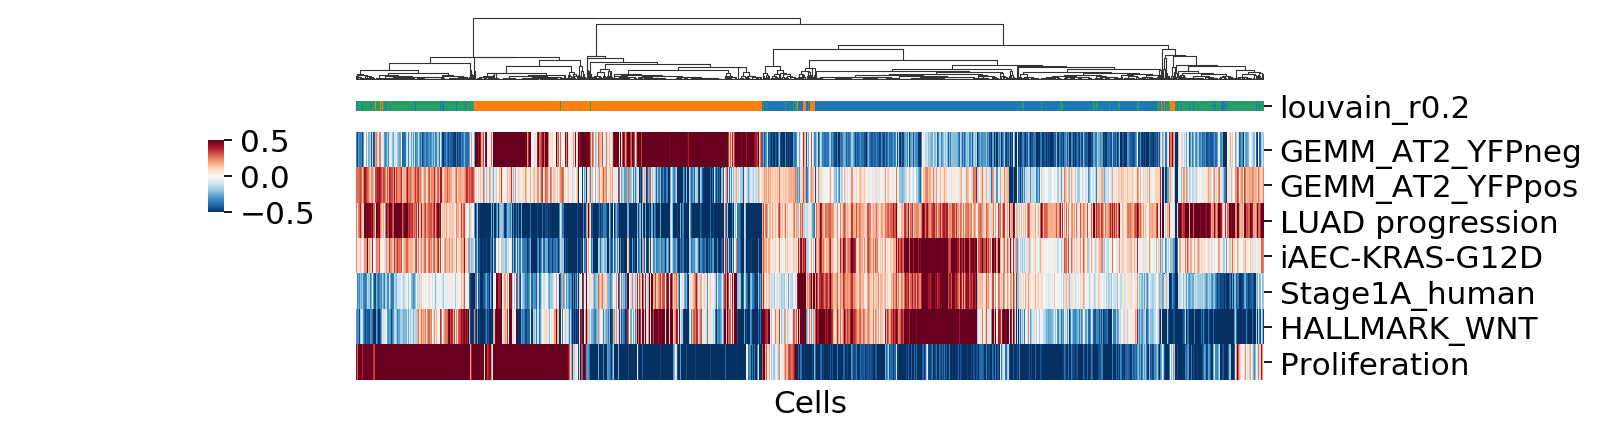

In [9]:
full_df = adata_subset.copy()

df = pd.DataFrame()

pathways=['GEMM_AT2_YFPneg','GEMM_AT2_YFPpos','iPSC_KRAS_HUMAN','GGO_sig_human','LUAD progression',
         'Proliferation', 'HALLMARK_WNT']

for path in pathways:
    df[path]=full_df.obs[path]

cols=['GEMM_AT2_YFPneg','GEMM_AT2_YFPpos','LUAD progression','iPSC_KRAS_HUMAN','GGO_sig_human','HALLMARK_WNT','Proliferation']
df = df[cols]

df = df.rename(columns={'GGO_sig_human': "Stage1A_human", "iPSC_KRAS_HUMAN": "iAEC-KRAS-G12D"})
    
df = df.T

full_df = adata_subset.copy()
louvain = full_df.obs['louvain_r0.2'].astype('object')
lut = dict(zip(louvain.unique(), ['#ff7f0e','#1f77b4','#279e68']))
col_colors = louvain.map(lut)

g = sb.clustermap(df, vmin=-0.5, vmax=0.5, center=0, cmap='RdBu_r', metric="correlation", row_cluster=False,
                   figsize=(10, 3), cbar_pos=(0.3, .5, .01, .15), # locxaxis,locyaxis,cbarwidth,cbarheight
                   col_colors=col_colors
                   ) 
ax = g.ax_heatmap
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel("Cells")

#### Correlation heatmap using lineage specific genes

Text(0.5, -186.31597222222229, 'Cells')

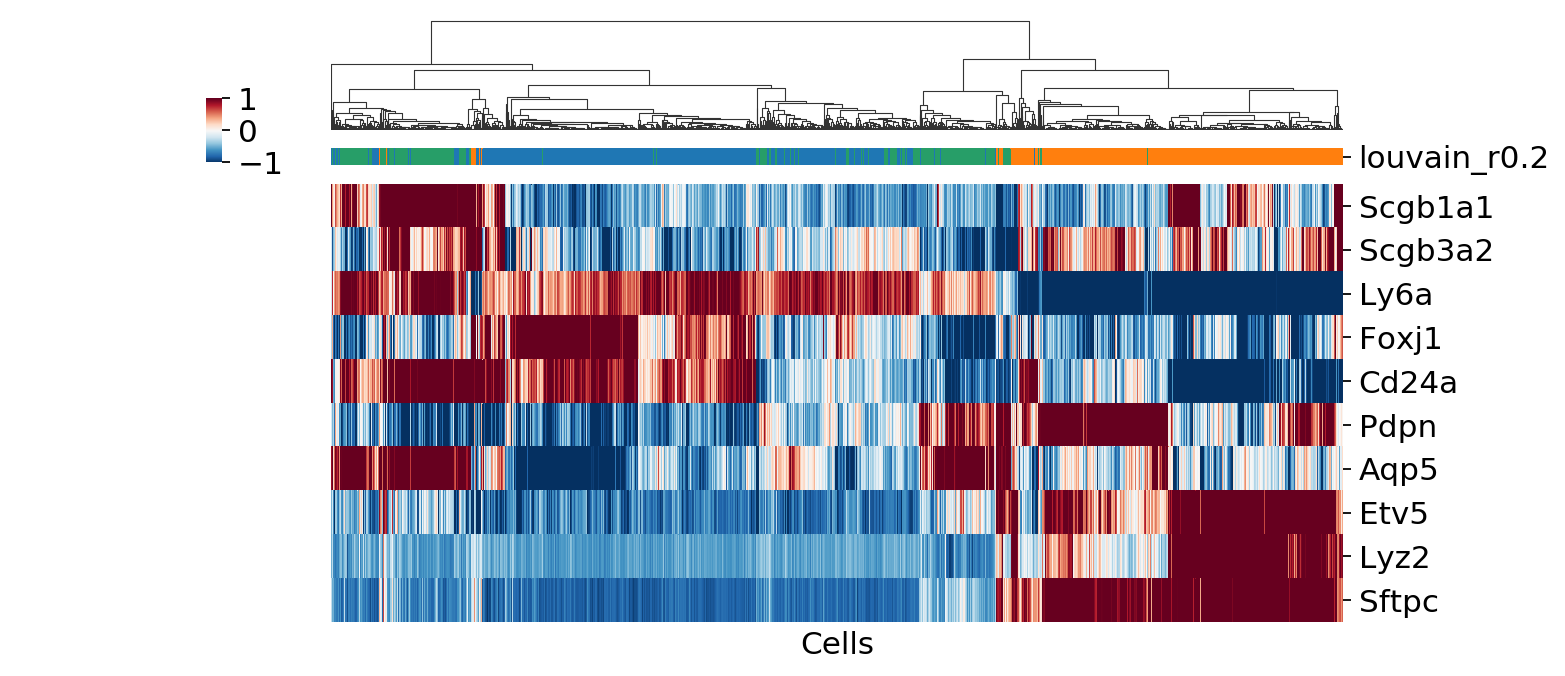

In [10]:
full_df = adata_subset[adata_subset.obs['louvain_r0.2'].isin(['0','1','2'])]

df = pd.DataFrame()

pathways=['AT1']

genes=['Lyz2','Etv5','Scgb1a1','Scgb3a2','Foxj1','Cd24a','Pdpn','Aqp5','Ly6a','Sftpc']

for path in pathways:
    df[path]=full_df.obs[path]
 
z_scores = sc.pp.scale(full_df, copy=True)

for gene in genes:
    df[gene]=z_scores[:, [gene]].to_df()

cols=['AT1','Scgb1a1','Scgb3a2','Ly6a','Foxj1','Cd24a','Pdpn','Aqp5','Etv5','Lyz2','Sftpc']

df = df[cols]
df =df.drop(['AT1'], axis=1)
df = df.T

full_df = adata_subset[adata_subset.obs['louvain_r0.2'].isin(['0','1','2'])]
louvain = full_df.obs['louvain_r0.2'].astype('object')
lut = dict(zip(louvain.unique(), ['#ff7f0e','#1f77b4','#279e68']))
col_colors = louvain.map(lut)

g = sb.clustermap(df, vmin=-1, vmax=1, center=0, cmap='RdBu_r', metric="correlation", row_cluster=False,
                   figsize=(10, 8), cbar_pos=(0.14, .85, .01, .05), # locxaxis,locyaxis,cbarwidth,cbarheight
                   col_colors=col_colors
                   ) 
ax = g.ax_heatmap
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel("Cells")